**1 - Desenvolva um notebook bem documentado em Python utilizando a biblioteca PySpark para apresentar as análises realizadas no trabalho do Hadoop**

In [ ]:
## configuração
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=bf5d9852d70c796dac2f68e6534ec87521206f36f11b431572a2a136edf53186
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, desc , col, max

ModuleNotFoundError: ignored

**1.1 - Time com o goleador mais eficiente**



In [ ]:
spark = SparkSession.builder.appName('analise_1').getOrCreate()
print(spark)

In [ ]:
df_goals = spark.read.csv('/content/drive/MyDrive/Colab Notebooks/analise_dados_com_spark/goals.csv', inferSchema=True, header=True)

In [ ]:
df_goals.createOrReplaceTempView('goals')

In [ ]:
query_df_goals = spark.sql('SELECT * FROM goals limit 5')

In [ ]:
query_df_goals.show()

+------+-----------+-----------+----------+-----+----------+---------+-------+------+-----------+-------------+---------+------------+
|serial|player_name|       club|  position|goals|right_foot|left_foot|headers|others|inside_area|outside_areas|penalties|match_played|
+------+-----------+-----------+----------+-----+----------+---------+-------+------+-----------+-------------+---------+------------+
|     1|    Benzema|Real Madrid|   Forward|   15|        11|        1|      3|     0|         13|            2|        3|          12|
|     2|Lewandowski|     Bayern|   Forward|   13|         8|        3|      1|     1|         13|            0|        3|          10|
|     3|     Haller|       Ajax|   Forward|   11|         3|        4|      3|     1|         11|            0|        1|           8|
|     4|      Salah|  Liverpool|   Forward|    8|         0|        8|      0|     0|          7|            1|        1|          13|
|     5|     Nkunku|    Leipzig|Midfielder|    7|      

In [ ]:
df_attempts = spark.read.csv('/content/drive/MyDrive/Colab Notebooks/analise_dados_com_spark/attempts.csv', inferSchema=True, header=True)

In [ ]:
df_attempts.createOrReplaceTempView('attempts')

In [ ]:
query_df_attempts = spark.sql('SELECT * FROM attempts limit 5')

In [ ]:
query_df_attempts.show()

+------+-----------+-----------+----------+--------------+---------+----------+-------+------------+
|serial|player_name|       club|  position|total_attempts|on_target|off_target|blocked|match_played|
+------+-----------+-----------+----------+--------------+---------+----------+-------+------------+
|     1|    Benzema|Real Madrid|   Forward|            45|       23|        13|      9|          12|
|     2|      Salah|  Liverpool|   Forward|            42|       22|        11|      9|          13|
|     3|     Mahrez|  Man. City|Midfielder|            37|       18|         8|     11|          12|
|     4|       Sané|     Bayern|Midfielder|            33|       13|        12|      8|          10|
|     5|Lewandowski|     Bayern|   Forward|            31|       19|         8|      4|          10|
+------+-----------+-----------+----------+--------------+---------+----------+-------+------------+



In [ ]:
query = """
WITH top_5 as (
SELECT g.player_name, g.goals
  FROM goals g
ORDER BY g.goals DESC
LIMIT 5)
SELECT att.club,
       att.player_name,
       att.total_attempts,
       tp.goals,
       (CAST(tp.goals AS FLOAT) / att.total_attempts) * 100 AS mean_goals
  FROM attempts att
  JOIN top_5 tp ON tp.player_name = att.player_name
ORDER BY mean_goals desc;
"""
query_df = spark.sql(query);

In [ ]:
query_df.show()

+-----------+-----------+--------------+-----+------------------+
|       club|player_name|total_attempts|goals|        mean_goals|
+-----------+-----------+--------------+-----+------------------+
|       Ajax|     Haller|            24|   11| 45.83333333333333|
|     Bayern|Lewandowski|            31|   13|41.935483870967744|
|    Leipzig|     Nkunku|            17|    7| 41.17647058823529|
|Real Madrid|    Benzema|            45|   15| 33.33333333333333|
|  Liverpool|      Salah|            42|    8|19.047619047619047|
+-----------+-----------+--------------+-----+------------------+



**1.2 - Time composto com os melhores jogadores de defesa**

Para poder chegar no resultado, foi necessário colocar peso em alguns dados, exclusivamente pessoal. No nosso esquema de dados, temos:

**Defending**
*   balls_recovered = 0.5
*   tackles = 0.5
*   t_won = 1

**Disciplinary**
*   fouls_committed = -0.5
*   red = -2
*   yellow = -1





In [ ]:
df_defending = spark.read.csv('/content/drive/MyDrive/Colab Notebooks/analise_dados_com_spark/defending.csv', inferSchema=True, header=True)

In [ ]:
df_defending.createOrReplaceTempView('defending')

In [ ]:
df_disciplinary = spark.read.csv('/content/drive/MyDrive/Colab Notebooks/analise_dados_com_spark/disciplinary.csv', inferSchema=True, header=True)

In [ ]:
df_disciplinary.createOrReplaceTempView('disciplinary')

Sendo assim, rodamos o SQL abaixo e obtivemos os primeiros jogadores no ranking de defesa, com Casemiro (Real Madrid) em 1º, seguido por Otamendi (Benfica) em 2º e Fabinho (Liverpool) em 3º.

In [ ]:
query = """
SELECT club, player_name, sum(pt_br) + sum(pt_tk) + sum(pt_tw) +  sum(pt_fo) + sum(pt_rd) + sum(pt_yw) AS resultado
  FROM (
        SELECT dc.club, dc.player_name, cast(0.5 * df.balls_recoverd AS FLOAT) AS pt_br, cast(0.5 * df.tackles AS FLOAT) AS pt_tk, df.t_won AS pt_tw, cast(-0.5 * dc.fouls_committed AS FLOAT) AS pt_fo, (-2 * dc.red) AS pt_rd, (-1 * dc.yellow) AS pt_yw
          FROM defending df
          JOIN disciplinary dc ON dc.player_name = df.player_name
         WHERE df.position IN ('Midfielder', 'Defender')
           AND df.match_played > 5
  ) t
GROUP BY club, player_name
ORDER BY resultado DESC;
"""
query_df = spark.sql(query);

In [ ]:
query_df.show()

+-----------+-----------------+---------+
|       club|      player_name|resultado|
+-----------+-----------------+---------+
|Real Madrid|         Casemiro|     52.0|
|    Benfica|         Otamendi|     50.0|
|  Liverpool|          Fabinho|     48.5|
| Villarreal|            Foyth|     41.0|
| Villarreal|           Albiol|     40.5|
|Real Madrid|            Alaba|     39.0|
|   Atlético|         Reinildo|     39.0|
|       LOSC|            André|     38.0|
|  Liverpool|           Konaté|     38.0|
|Real Madrid|     Éder Militão|     37.0|
|    Chelsea|     Thiago Silva|     36.0|
|     Bayern|           Pavard|     36.0|
|    Sheriff|Fernando Costanza|     35.0|
| Villarreal|           Parejo|     34.5|
|  Liverpool| Thiago Alcántara|     34.5|
|    Benfica|       Vertonghen|     33.5|
| Young Boys|           Lauper|     33.0|
| Young Boys|           Camara|     32.5|
|    Benfica|            Weigl|     32.0|
|       Ajax|         Mazraoui|     31.5|
+-----------+-----------------+---

Mas será que o Real Madrid possui no geral, os melhores jogadores de defesa? Para descobrir rodamos a consulta abaixo:

In [ ]:
query = """
WITH dados_top_def AS (
SELECT club, player_name, sum(pt_br) + sum(pt_tk) + sum(pt_tw) +  sum(pt_fo) + sum(pt_rd) + sum(pt_yw) AS resultado
  FROM (
        SELECT dc.club, dc.player_name, cast(0.5 * df.balls_recoverd AS FLOAT) AS pt_br, cast(0.5 * df.tackles AS FLOAT) AS pt_tk, df.t_won AS pt_tw, cast(-0.5 * dc.fouls_committed AS FLOAT) as pt_fo, (-2 * dc.red) AS pt_rd, (-1 * dc.yellow) AS pt_yw
          FROM defending df
          JOIN disciplinary dc ON dc.player_name = df.player_name
         WHERE df.position IN ('Midfielder', 'Defender')
           AND df.match_played > 5
  ) t
GROUP BY club, player_name)
SELECT club, sum(resultado) as resultado
  FROM dados_top_def
GROUP BY club
ORDER BY resultado DESC;
"""
query_df = spark.sql(query);

In [ ]:
query_df.show()

+-----------+---------+
|       club|resultado|
+-----------+---------+
|Real Madrid|    280.0|
|  Liverpool|    246.0|
| Villarreal|    226.0|
|  Man. City|    212.5|
|      Inter|    193.0|
|     Bayern|    182.0|
|   Atlético|    180.5|
|    Benfica|    179.5|
|    Chelsea|    174.0|
|   Salzburg|    150.0|
|       LOSC|    133.5|
|    Sheriff|    127.0|
|       Ajax|    124.0|
|   Juventus|    120.5|
| Young Boys|    115.0|
|Sporting CP|    100.0|
|      Paris|     92.5|
|Man. United|     89.0|
|      Zenit|     82.0|
|Club Brugge|     81.5|
+-----------+---------+
only showing top 20 rows



**1.3 - **

In [ ]:
df_goalkeeping = spark.read.csv('/content/drive/MyDrive/Colab Notebooks/analise_dados_com_spark/goalkeeping.csv', inferSchema=True, header=True)

In [ ]:

df.groupBy('nome_da_coluna').count().show()
df.groupBy('nome_da_coluna').min().show()
df.groupBy('nome_da_coluna').max().show()
df.groupBy('nome_da_coluna').avg().show()
df.groupBy('nome_da_coluna').sum().show()

**2 - Desenvolva um notebook bem documentado em Python utilizando a biblioteca PySpark para treinar um modelo de aprendizado de máquina**

In [ ]:
# Importando as bibliotecas necessárias
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
# Criando uma sessão Spark
spark = SparkSession.builder.appName('linear_regression').getOrCreate()

In [ ]:
# Carregando os dados
df = spark.read.csv('/content/drive/MyDrive/Colab Notebooks/analise_dados_com_spark/Covid Data.csv', inferSchema=True, header=True)

In [ ]:
# Visualizando o dataframe
df.show()

+-----+------------+---+------------+----------+-------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+---+
|USMER|MEDICAL_UNIT|SEX|PATIENT_TYPE| DATE_DIED|INTUBED|PNEUMONIA|AGE|PREGNANT|DIABETES|COPD|ASTHMA|INMSUPR|HIPERTENSION|OTHER_DISEASE|CARDIOVASCULAR|OBESITY|RENAL_CHRONIC|TOBACCO|CLASIFFICATION_FINAL|ICU|
+-----+------------+---+------------+----------+-------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+---+
|    2|           1|  1|           1|03/05/2020|     97|        1| 65|       2|       2|   2|     2|      2|           1|            2|             2|      2|            2|      2|                   3| 97|
|    2|           1|  2|           1|03/06/2020|     97|        1| 72|      97|       2|   2|     2|      2|           1|            2|             2|      1|            1|    

In [ ]:
from pyspark.sql import functions as F

In [ ]:
# Suponha que 'df' é seu DataFrame PySpark
for c in df.columns:
    unique_values = df.select(c).distinct().count()
    if unique_values == 3 or unique_values == 4:
        print(f"{c}: {unique_values}")

INTUBED: 4
PNEUMONIA: 3
PREGNANT: 4
DIABETES: 3
COPD: 3
ASTHMA: 3
INMSUPR: 3
HIPERTENSION: 3
OTHER_DISEASE: 3
CARDIOVASCULAR: 3
OBESITY: 3
RENAL_CHRONIC: 3
TOBACCO: 3
ICU: 4


In [ ]:
# Suponha que 'df' é seu DataFrame PySpark
for c in df.columns:
    unique_values = df.select(c).distinct().count()
    if unique_values == 3 or unique_values == 4:
        df.groupBy(c).agg((F.count(c)/df.count()).alias('normalize')).show()
        print('--'*50)

+-------+--------------------+
|INTUBED|           normalize|
+-------+--------------------+
|      1|0.032096893402951625|
|     97|  0.8092353908876332|
|      2| 0.15168204467968432|
|     99|0.006985671029730825|
+-------+--------------------+

----------------------------------------------------------------------------------------------------
+---------+--------------------+
|PNEUMONIA|           normalize|
+---------+--------------------+
|        1| 0.13355077128483894|
|        2|  0.8511875640750542|
|       99|0.015261664640106812|
+---------+--------------------+

----------------------------------------------------------------------------------------------------
+--------+--------------------+
|PREGNANT|           normalize|
+--------+--------------------+
|       1|0.007754333261807691|
|      97| 0.49925947118708724|
|      98|0.003580096798035429|
|       2|  0.4894060987530696|
+--------+--------------------+

------------------------------------------------------------

In [ ]:
df = df.withColumn('INTUBED', F.when(df['INTUBED'] == 97, 0).otherwise(df['INTUBED']))
df = df.withColumn('INTUBED', F.when(df['INTUBED'].isin([2, 99]), 1).otherwise(df['INTUBED']))

df = df.withColumn('PNEUMONIA', F.when(df['PNEUMONIA'] == 2, 0).otherwise(df['PNEUMONIA']))
df = df.withColumn('PNEUMONIA', F.when(df['PNEUMONIA'] == 99, 1).otherwise(df['PNEUMONIA']))

df = df.withColumn('PREGNANT', F.when(df['PREGNANT'] == 97, 0).otherwise(df['PREGNANT']))
df = df.withColumn('PREGNANT', F.when(df['PREGNANT'].isin([2, 98]), 1).otherwise(df['PREGNANT']))

df = df.withColumn('DIABETES', F.when(df['DIABETES'] == 2, 0).otherwise(df['DIABETES']))
df = df.withColumn('DIABETES', F.when(df['DIABETES'] == 98, 1).otherwise(df['DIABETES']))

df = df.withColumn('COPD', F.when(df['COPD'] == 2, 0).otherwise(df['COPD']))
df = df.withColumn('COPD', F.when(df['COPD'] == 98, 1).otherwise(df['COPD']))

df = df.withColumn('ASTHMA', F.when(df['ASTHMA'] == 2, 0).otherwise(df['ASTHMA']))
df = df.withColumn('ASTHMA', F.when(df['ASTHMA'] == 98, 1).otherwise(df['ASTHMA']))

df = df.withColumn('INMSUPR', F.when(df['INMSUPR'] == 2, 0).otherwise(df['INMSUPR']))
df = df.withColumn('INMSUPR', F.when(df['INMSUPR'] == 98, 1).otherwise(df['INMSUPR']))

df = df.withColumn('HIPERTENSION', F.when(df['HIPERTENSION'] == 2, 0).otherwise(df['HIPERTENSION']))
df = df.withColumn('HIPERTENSION', F.when(df['HIPERTENSION'] == 98, 1).otherwise(df['HIPERTENSION']))

df = df.withColumn('OTHER_DISEASE', F.when(df['OTHER_DISEASE'] == 2, 0).otherwise(df['OTHER_DISEASE']))
df = df.withColumn('OTHER_DISEASE', F.when(df['OTHER_DISEASE'] == 98, 1).otherwise(df['OTHER_DISEASE']))

df = df.withColumn('CARDIOVASCULAR', F.when(df['CARDIOVASCULAR'] == 2, 0).otherwise(df['CARDIOVASCULAR']))
df = df.withColumn('CARDIOVASCULAR', F.when(df['CARDIOVASCULAR'] == 98, 1).otherwise(df['CARDIOVASCULAR']))

df = df.withColumn('OBESITY', F.when(df['OBESITY'] == 2, 0).otherwise(df['OBESITY']))
df = df.withColumn('OBESITY', F.when(df['OBESITY'] == 98, 1).otherwise(df['OBESITY']))

df = df.withColumn('TOBACCO', F.when(df['TOBACCO'] == 2, 0).otherwise(df['TOBACCO']))
df = df.withColumn('TOBACCO', F.when(df['TOBACCO'] == 98, 1).otherwise(df['TOBACCO']))

df = df.withColumn('ICU', F.when(df['ICU'] == 97, 0).otherwise(df['ICU']))
df = df.withColumn('ICU', F.when(df['ICU'].isin([2, 99]), 1).otherwise(df['ICU']))

df = df.withColumn('RENAL_CHRONIC', F.when(df['RENAL_CHRONIC'] == 2, 0).otherwise(df['RENAL_CHRONIC']))
df = df.withColumn('RENAL_CHRONIC', F.when(df['RENAL_CHRONIC'] == 98, 1).otherwise(df['RENAL_CHRONIC']))

In [ ]:
df.show()

+-----+------------+---+------------+----------+-------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+---+-----+
|USMER|MEDICAL_UNIT|SEX|PATIENT_TYPE| DATE_DIED|INTUBED|PNEUMONIA|AGE|PREGNANT|DIABETES|COPD|ASTHMA|INMSUPR|HIPERTENSION|OTHER_DISEASE|CARDIOVASCULAR|OBESITY|RENAL_CHRONIC|TOBACCO|CLASIFFICATION_FINAL|ICU|DEATH|
+-----+------------+---+------------+----------+-------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+---+-----+
|    2|           1|  1|           1|03/05/2020|      0|        1| 65|       1|       0|   0|     0|      0|           1|            0|             0|      0|            0|      0|                   3|  0|    1|
|    2|           1|  2|           1|03/06/2020|      0|        1| 72|       0|       0|   0|     0|      0|           1|            0|             0|  

In [ ]:
df = df.withColumn("DEATH", F.when(F.col("DATE_DIED") == "9999-99-99", 0).otherwise(1))

In [ ]:
df.show()

+-----+------------+---+------------+----------+-------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+---+-----+
|USMER|MEDICAL_UNIT|SEX|PATIENT_TYPE| DATE_DIED|INTUBED|PNEUMONIA|AGE|PREGNANT|DIABETES|COPD|ASTHMA|INMSUPR|HIPERTENSION|OTHER_DISEASE|CARDIOVASCULAR|OBESITY|RENAL_CHRONIC|TOBACCO|CLASIFFICATION_FINAL|ICU|DEATH|
+-----+------------+---+------------+----------+-------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+---+-----+
|    2|           1|  1|           1|03/05/2020|      0|        1| 65|       1|       0|   0|     0|      0|           1|            0|             0|      0|            0|      0|                   3|  0|    1|
|    2|           1|  2|           1|03/06/2020|      0|        1| 72|       0|       0|   0|     0|      0|           1|            0|             0|  

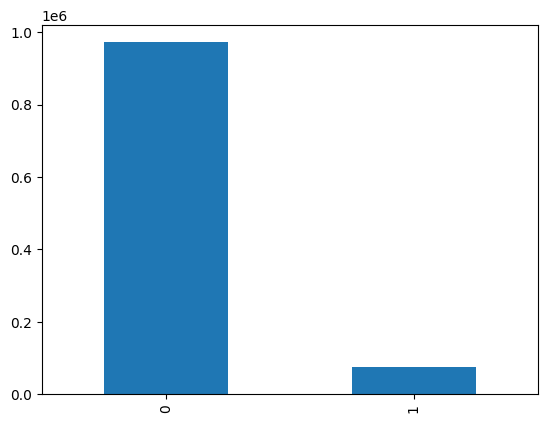

In [ ]:
import matplotlib.pyplot as plt

# Suponha que 'df' é seu DataFrame PySpark
pandas_df = df.toPandas()

# Cria um gráfico de barras da coluna 'DEATH'
pandas_df['DEATH'].value_counts().plot(kind='bar')

# Mostra o gráfico
plt.show()

In [ ]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=["AGE", "INTUBED", "PNEUMONIA", "DIABETES", "OBESITY", "CARDIOVASCULAR", "TOBACCO" ], outputCol="features")
dados = assembler.transform(df).select("DEATH", "features").withColumnRenamed("DEATH", "label")

dados.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    1|(7,[0,2],[65.0,1.0])|
|    1|(7,[0,2,4],[72.0,...|
|    1|(7,[0,1,3],[55.0,...|
|    1|      (7,[0],[53.0])|
|    1|(7,[0,3],[68.0,1.0])|
|    0|(7,[0,1,2],[40.0,...|
|    0|      (7,[0],[64.0])|
|    0|(7,[0,2,3],[64.0,...|
|    0|[37.0,1.0,0.0,1.0...|
|    0|(7,[0,1],[25.0,1.0])|
|    0|      (7,[0],[38.0])|
|    0|(7,[0,1],[24.0,1.0])|
|    0|(7,[0,1],[30.0,1.0])|
|    0|      (7,[0],[55.0])|
|    0|(7,[0,3],[48.0,1.0])|
|    0|      (7,[0],[23.0])|
|    0|(7,[0,1,2],[80.0,...|
|    0|      (7,[0],[61.0])|
|    0|      (7,[0],[54.0])|
|    0|      (7,[0],[64.0])|
+-----+--------------------+
only showing top 20 rows



In [ ]:
train_data, test_data = dados.randomSplit([0.75, 0.25], seed=42)

In [ ]:
from pyspark.ml.regression import LinearRegression

# Inicializando um modelo de Regressão Linear
lr = LinearRegression(regParam=0.3)

# Treinando o modelo
model = lr.fit(train_data)

In [ ]:
# Fazendo previsões no conjunto de teste
predictions = model.transform(test_data).show()


+-----+---------+--------------------+
|label| features|          prediction|
+-----+---------+--------------------+
|    0|(7,[],[])|-0.03428625672844...|
|    0|(7,[],[])|-0.03428625672844...|
|    0|(7,[],[])|-0.03428625672844...|
|    0|(7,[],[])|-0.03428625672844...|
|    0|(7,[],[])|-0.03428625672844...|
|    0|(7,[],[])|-0.03428625672844...|
|    0|(7,[],[])|-0.03428625672844...|
|    0|(7,[],[])|-0.03428625672844...|
|    0|(7,[],[])|-0.03428625672844...|
|    0|(7,[],[])|-0.03428625672844...|
|    0|(7,[],[])|-0.03428625672844...|
|    0|(7,[],[])|-0.03428625672844...|
|    0|(7,[],[])|-0.03428625672844...|
|    0|(7,[],[])|-0.03428625672844...|
|    0|(7,[],[])|-0.03428625672844...|
|    0|(7,[],[])|-0.03428625672844...|
|    0|(7,[],[])|-0.03428625672844...|
|    0|(7,[],[])|-0.03428625672844...|
|    0|(7,[],[])|-0.03428625672844...|
|    0|(7,[],[])|-0.03428625672844...|
+-----+---------+--------------------+
only showing top 20 rows

